<a href="https://colab.research.google.com/github/vanithakattumuri/PAMI/blob/main/notebooks/partialPeriodicPatternInMultipleTimeSeries/basic/PPGrowth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Partial Periodic patterns in Multiple TimeSeries in a Temporal Databases using PPGrowth

This tutorial has two parts. In the first part, we describe the basic approach to find Partial Periodic patterns in Multiple TimeSeries in a temporal database using the PPGrowth algorithm. In the final part, we describe an advanced approach, where we evaluate the PPGrowth algorithm on a dataset at different periodic support threshold values.
***

# Prerequisites:

1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.9/883.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 13.9 MB/s eta 0:00:00
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=3ccf974f871151866c201b5c823829bc417cc76c88d4a708769ce34cf55b28b3
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4753 sha256=e4b05698bb9a397b6a85692da3920e69606691bfa6afcd605a4fc6d659a2d686
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv #download a sample temporal database

--2023-11-17 02:43:33--  https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.95.161.176, 150.31.244.160
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.95.161.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4606762 (4.4M) [text/csv]
Saving to: ‘Temporal_T10I4D100K.csv’

Temporal_T10I4D100K 100%[===================>]   4.39M  1.37MB/s    in 3.2s    

2023-11-17 02:43:37 (1.37 MB/s) - ‘Temporal_T10I4D100K.csv’ saved [4606762/4606762]



3.   Printing few lines of a dataset to know its format.

In [3]:
!head -2 Temporal_T10I4D100K.csv

1	25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
2	39	120	124	205	401	581	704	814	825	834


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding Partial Periodic patterns in Multiple TimeSeries using PPGrowth

### Step 1: Understanding the statistics of a database to choose an appropriate periodic support (periodicSup) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.temporalDatabaseStats as stats

#specify the file name
inputFile = 'Temporal_T10I4D100K.csv'

#initialize the class
obj=stats.temporalDatabaseStats(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99913
Total number of items : 870
Database sparsity : 0.9883887027691103
Minimum Transaction Size : 1
Average Transaction Size : 10.10182859087406
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667115963877195
Variance in Transaction Sizes : 13.447874088362232


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

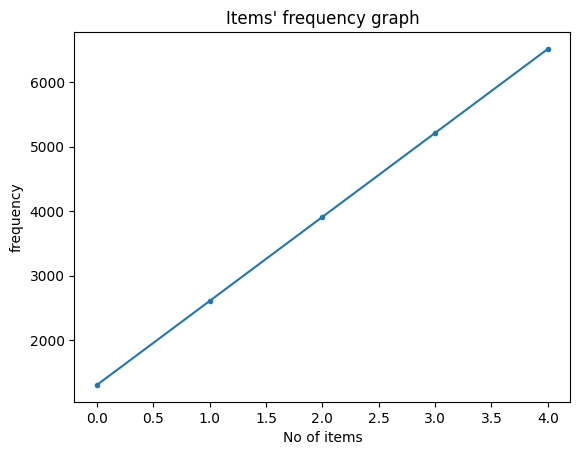

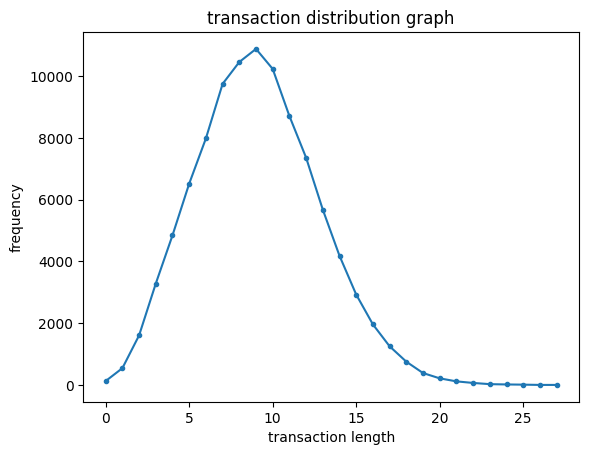

In [5]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *periodicSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _periodicSup_ value of 1000 (in count). We can increase or decrease the _periodicSup_ based on the number of patterns being generated.

In [6]:
PeriodCount = 5000  #PeriodCount is specified in count. However, the users can also specify PeriodCount between 0 and 1.
periodicSupportCount = 1000

### Step 4: Mining Partial Periodic patterns in Multiple TimeSeries using PPGrowth

In [11]:
from PAMI.partialPeriodicPatternInMultipleTimeSeries import PPGrowth  as alg #import the algorithm

obj = alg.PPGrowth(iFile=inputFile, period=PeriodCount, periodicSupport=periodicSupportCount, sep='\t') #initialize
obj.mine()            #start the mining process

obj.save('partialPeriodicPatternsInMultipleTimeSeriesAtperSupCount1000.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Periodic Frequent patterns were generated successfully using PPGrowth algorithm 
Total No of patterns: 385
Runtime: 14.044399976730347
Memory (RSS): 451764224
Memory (USS): 428314624


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [12]:
!head 'partialPeriodicPatternsInMultipleTimeSeriesAtperSupCount1000.txt'

912:1008:504 
511:1014:748 
428:1019:833 
266:1020:788 
325:1020:732 
201:1029:600 
366:1030:1013 
823:1031:677 
928:1032:683 
258:1035:692 


The storage format is: _partialPeriodicPatternInMultipleTimeseries:support_
***

## Part 2: Evaluating the PPGrowth algorithm on a dataset at different periodicSup values

### Step 1: Import the libraries and specify the input parameters

In [13]:
#Import the libraries
from PAMI.partialPeriodicPatternInMultipleTimeSeries import PPGrowth  as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Temporal_T10I4D100K.csv'
seperator='\t'
PeriodCount = 5000
periodicSupportCountList = [1000, 1500, 2000, 2500, 3000]
#periodicSupport can also specified between 0 to 1. E.g., periodicSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of PPGrowth

In [14]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'PeriodCount', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of PPGrowth algorithm

### Step 3: Execute the algorithm at different periodicSup values

In [15]:
for minSupCount in periodicSupportCountList:
    obj = alg.PPGrowth(iFile=inputFile, periodicSupport=minSupCount, period=PeriodCount, sep=seperator)
    obj.mine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['PPGrowth', minSupCount, PeriodCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Periodic Frequent patterns were generated successfully using PPGrowth algorithm 
Periodic Frequent patterns were generated successfully using PPGrowth algorithm 
Periodic Frequent patterns were generated successfully using PPGrowth algorithm 
Periodic Frequent patterns were generated successfully using PPGrowth algorithm 
Periodic Frequent patterns were generated successfully using PPGrowth algorithm 


### Step 4: Print the Result

In [16]:
print(result)

  algorithm  minSup  PeriodCount  patterns    runtime     memory
0  PPGrowth    1000         5000       385  12.224450  452337664
1  PPGrowth    1500         5000       237   9.264858  374980608
2  PPGrowth    2000         5000       155   6.491828  322408448
3  PPGrowth    2500         5000       107   5.214154  308989952
4  PPGrowth    3000         5000        60   5.486989  301764608


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

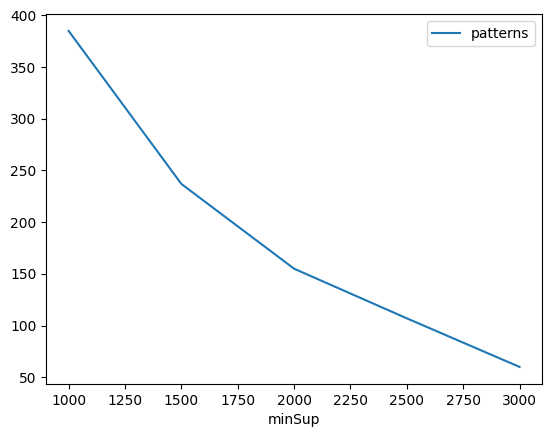

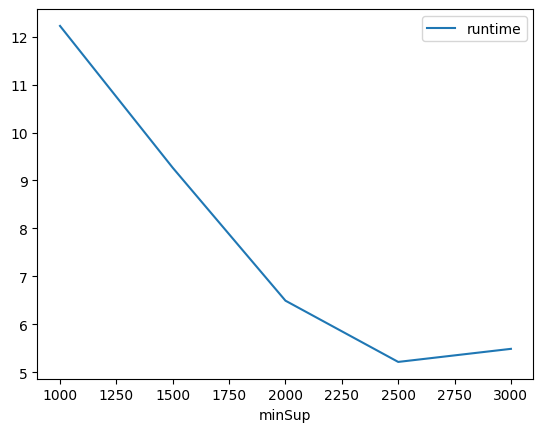

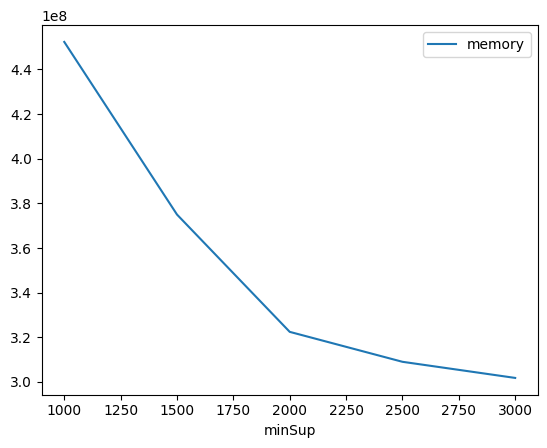

In [17]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib